# Plot Time Series Data for a Given Balancing Authority

In [1]:
# Start by importing the packages we need:
import os
import datetime
import yaml

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from matplotlib import pyplot 
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [2]:
# Identify the data and impage input and output directories:
ba_data_input_dir =  '/Users/burl878/Documents/Code/code_repos/tell/tell/tell_data/tell_quickstarter_data/outputs/compiled_historical_data/'
ba_to_process_input_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2025_ldrd/data/'
cleaned_ba_data_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2025_ldrd/data/cleaned_historical_data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2025_ldrd/figures/'


## Set the List of Balancing Authorities to Plot

BAs used in this analysis are controlled by a master file `balancing_authorities_modeled.yml` stored in the `/data` directory.

In [3]:
# Read the yml file into a dictionary:
with open((ba_to_process_input_dir + 'balancing_authority_modeled.yml'), 'r') as yml:
     ba_list = yaml.load(yml, Loader=yaml.FullLoader)
     bas = [i for i in ba_list.keys()]

# Return the list of BAs to process/plot:
bas


['AZPS', 'BPAT', 'CISO', 'ERCO', 'FPL', 'ISNE', 'PJM', 'SWPP']

## Create a Function to Clean the Load Data for a Given Balancing Authority


In [39]:
def clean_load_time_series(ba_to_process: str, start_year: int, end_year: int, ba_data_input_dir: str, cleaned_ba_data_output_dir: str):
    # Read in the compiled historical dataset created by the TELL preprocessing:
    ba_df = pd.read_csv((ba_data_input_dir + ba_to_process + '_historical_data.csv'))

    # Convert the time columns into one datetime variable:
    ba_df['Time_UTC'] = pd.to_datetime(ba_df[['Year', 'Month', 'Day', 'Hour']])
    
    # Create new columns with the cleaned demand and the change in demand between sequential hours:
    ba_df['Cleaned_Demand_MWh'] = ba_df['Adjusted_Demand_MWh']
    ba_df['Demand_Change_MWh'] = ba_df['Adjusted_Demand_MWh'].diff()

    # Replace all hours with demands of 0 MWh with NaN:
    ba_df['Cleaned_Demand_MWh'] = ba_df['Cleaned_Demand_MWh'].replace(0, np.nan)

    # Replace all rows in which the hour-to-hour change in demand is more than 10 times greater than the mean change with NaN:
    ba_df.loc[abs(ba_df['Demand_Change_MWh']) >= (10*(abs(ba_df['Demand_Change_MWh']).mean())), 'Cleaned_Demand_MWh'] = np.nan

    # Replace all rows in which the hourly load is more than 5 standard deviations from the mean value with NaN:
    ba_df.loc[ba_df['Adjusted_Demand_MWh'] >= ((5*ba_df['Adjusted_Demand_MWh'].std()) + ba_df['Adjusted_Demand_MWh'].mean()), 'Cleaned_Demand_MWh'] = np.nan
    
    # Set the output file name:
    csv_output_filename = (cleaned_ba_data_output_dir + ba_to_process + '_cleaned_historical_data.csv')

    # Write out the dataframe to a .csv file:
    ba_df.to_csv(csv_output_filename, sep=',', index=False)


In [42]:
# Loop over the BAs and clean the load data for each one:
for ba in bas:
    clean_load_time_series(ba_to_process = ba,
                           start_year = 2016,
                           end_year = 2023,
                           ba_data_input_dir = ba_data_input_dir,
                           cleaned_ba_data_output_dir = cleaned_ba_data_output_dir)


## Create a Function to Create the Quick Look Plot for a Given Balancing Authority


In [56]:
def plot_load_weather_time_series(ba_to_plot: str, start_year: int, end_year: int, ba_data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    # Read in the cleaned historical data file:
    ba_df = pd.read_csv((cleaned_ba_data_output_dir + ba_to_plot + '_cleaned_historical_data.csv'))

    # Convert the time columns into one datetime variable:
    ba_df['Time_UTC'] = pd.to_datetime(ba_df[['Year', 'Month', 'Day', 'Hour']])
    
    # Convert the temperature from Kelvin to Fahrenheit:,
    ba_df['T2'] = (1.8 * (ba_df['T2'] - 273)) + 32

    # Convert the populations into millions of people:
    ba_df['Total_Population'] = ba_df['Total_Population']/1000000
    
    # Make the plot:
    plt.figure(figsize=(35, 25))
    plt.rcParams['font.size'] = 18
    plt.subplot(411)
    plt.grid(True)
    plt.plot(ba_df['Time_UTC'], ba_df['Adjusted_Demand_MWh'], color='k', linestyle='-', linewidth=0.5)
    plt.xlim([datetime.date(start_year, 1, 1), datetime.date(end_year+1, 1, 1)])
    plt.ylim([(ba_df['Adjusted_Demand_MWh'].min() - 0.1*ba_df['Adjusted_Demand_MWh'].min()), (ba_df['Adjusted_Demand_MWh'].max() + 0.1*ba_df['Adjusted_Demand_MWh'].max())])
    plt.ylabel('EIA 930 Adjusted Demand [MWh]', fontsize=18)
    plt.title(('Raw Hourly Electricity Demand in ' + ba_to_plot + ' (Peak = ' + str(ba_df['Adjusted_Demand_MWh'].max().round(0)) + ' MWh)'), fontsize=21)
    plt.title('a)', loc='left', fontsize=18)

    plt.subplot(412)
    plt.grid(True)
    plt.plot(ba_df['Time_UTC'], ba_df['Cleaned_Demand_MWh'], color='b', linestyle='-', linewidth=0.5)
    plt.xlim([datetime.date(start_year, 1, 1), datetime.date(end_year+1, 1, 1)])
    plt.ylim([(ba_df['Adjusted_Demand_MWh'].min() - 0.1*ba_df['Adjusted_Demand_MWh'].min()), (ba_df['Adjusted_Demand_MWh'].max() + 0.1*ba_df['Adjusted_Demand_MWh'].max())])
    plt.ylabel('Cleaned Demand [MWh]', fontsize=18)
    plt.title(('Cleaned Demand in ' + ba_to_plot + ' (Peak = ' + str(ba_df['Cleaned_Demand_MWh'].max().round(0)) + ' MWh)'), fontsize=21)
    plt.title('b)', loc='left', fontsize=18)

    plt.subplot(413)
    plt.grid(True)
    plt.plot(ba_df['Time_UTC'], ba_df['T2'], color='r', linestyle='-', linewidth=0.5)
    plt.xlim([datetime.date(start_year, 1, 1), datetime.date(end_year+1, 1, 1)])
    plt.ylim([(ba_df['T2'].min() - 2), (ba_df['T2'].max() + 2)])
    plt.ylabel('Pop-Weighted Temperature [$^\circ$F]', fontsize=18)
    plt.title(('Hourly Temperature in ' + ba_to_plot + ' (Min = ' + str(ba_df['T2'].min().round(1)) + '$^\circ$F, Max = ' + str(ba_df['T2'].max().round(1)) + '$^\circ$F)'), fontsize=21)
    plt.title('c)', loc='left', fontsize=18)

    plt.subplot(414)
    plt.grid(True)
    plt.plot(ba_df['Time_UTC'], ba_df['Total_Population'], color='g', linestyle='-', linewidth=3)
    plt.xlim([datetime.date(start_year, 1, 1), datetime.date(end_year+1, 1, 1)])
    plt.ylim([(ba_df['Total_Population'].min() - 0.01*ba_df['Total_Population'].min()), (ba_df['Total_Population'].max() + 0.01*ba_df['Total_Population'].max())])
    plt.ylabel('Total Population [Millions]', fontsize=18)
    plt.title(('Estimated Population in ' + ba_to_plot + ' (Range = ' + str(1000000*(ba_df['Total_Population'].max() - ba_df['Total_Population'].min()).round(2)) + ')'), fontsize=21)
    plt.title('d)', loc='left', fontsize=18)

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + 'BA_Load_Weather_Time_Series_' + ba_to_plot + '.png'), dpi=image_resolution, bbox_inches='tight')
       # plt.close()


## Make the Plots


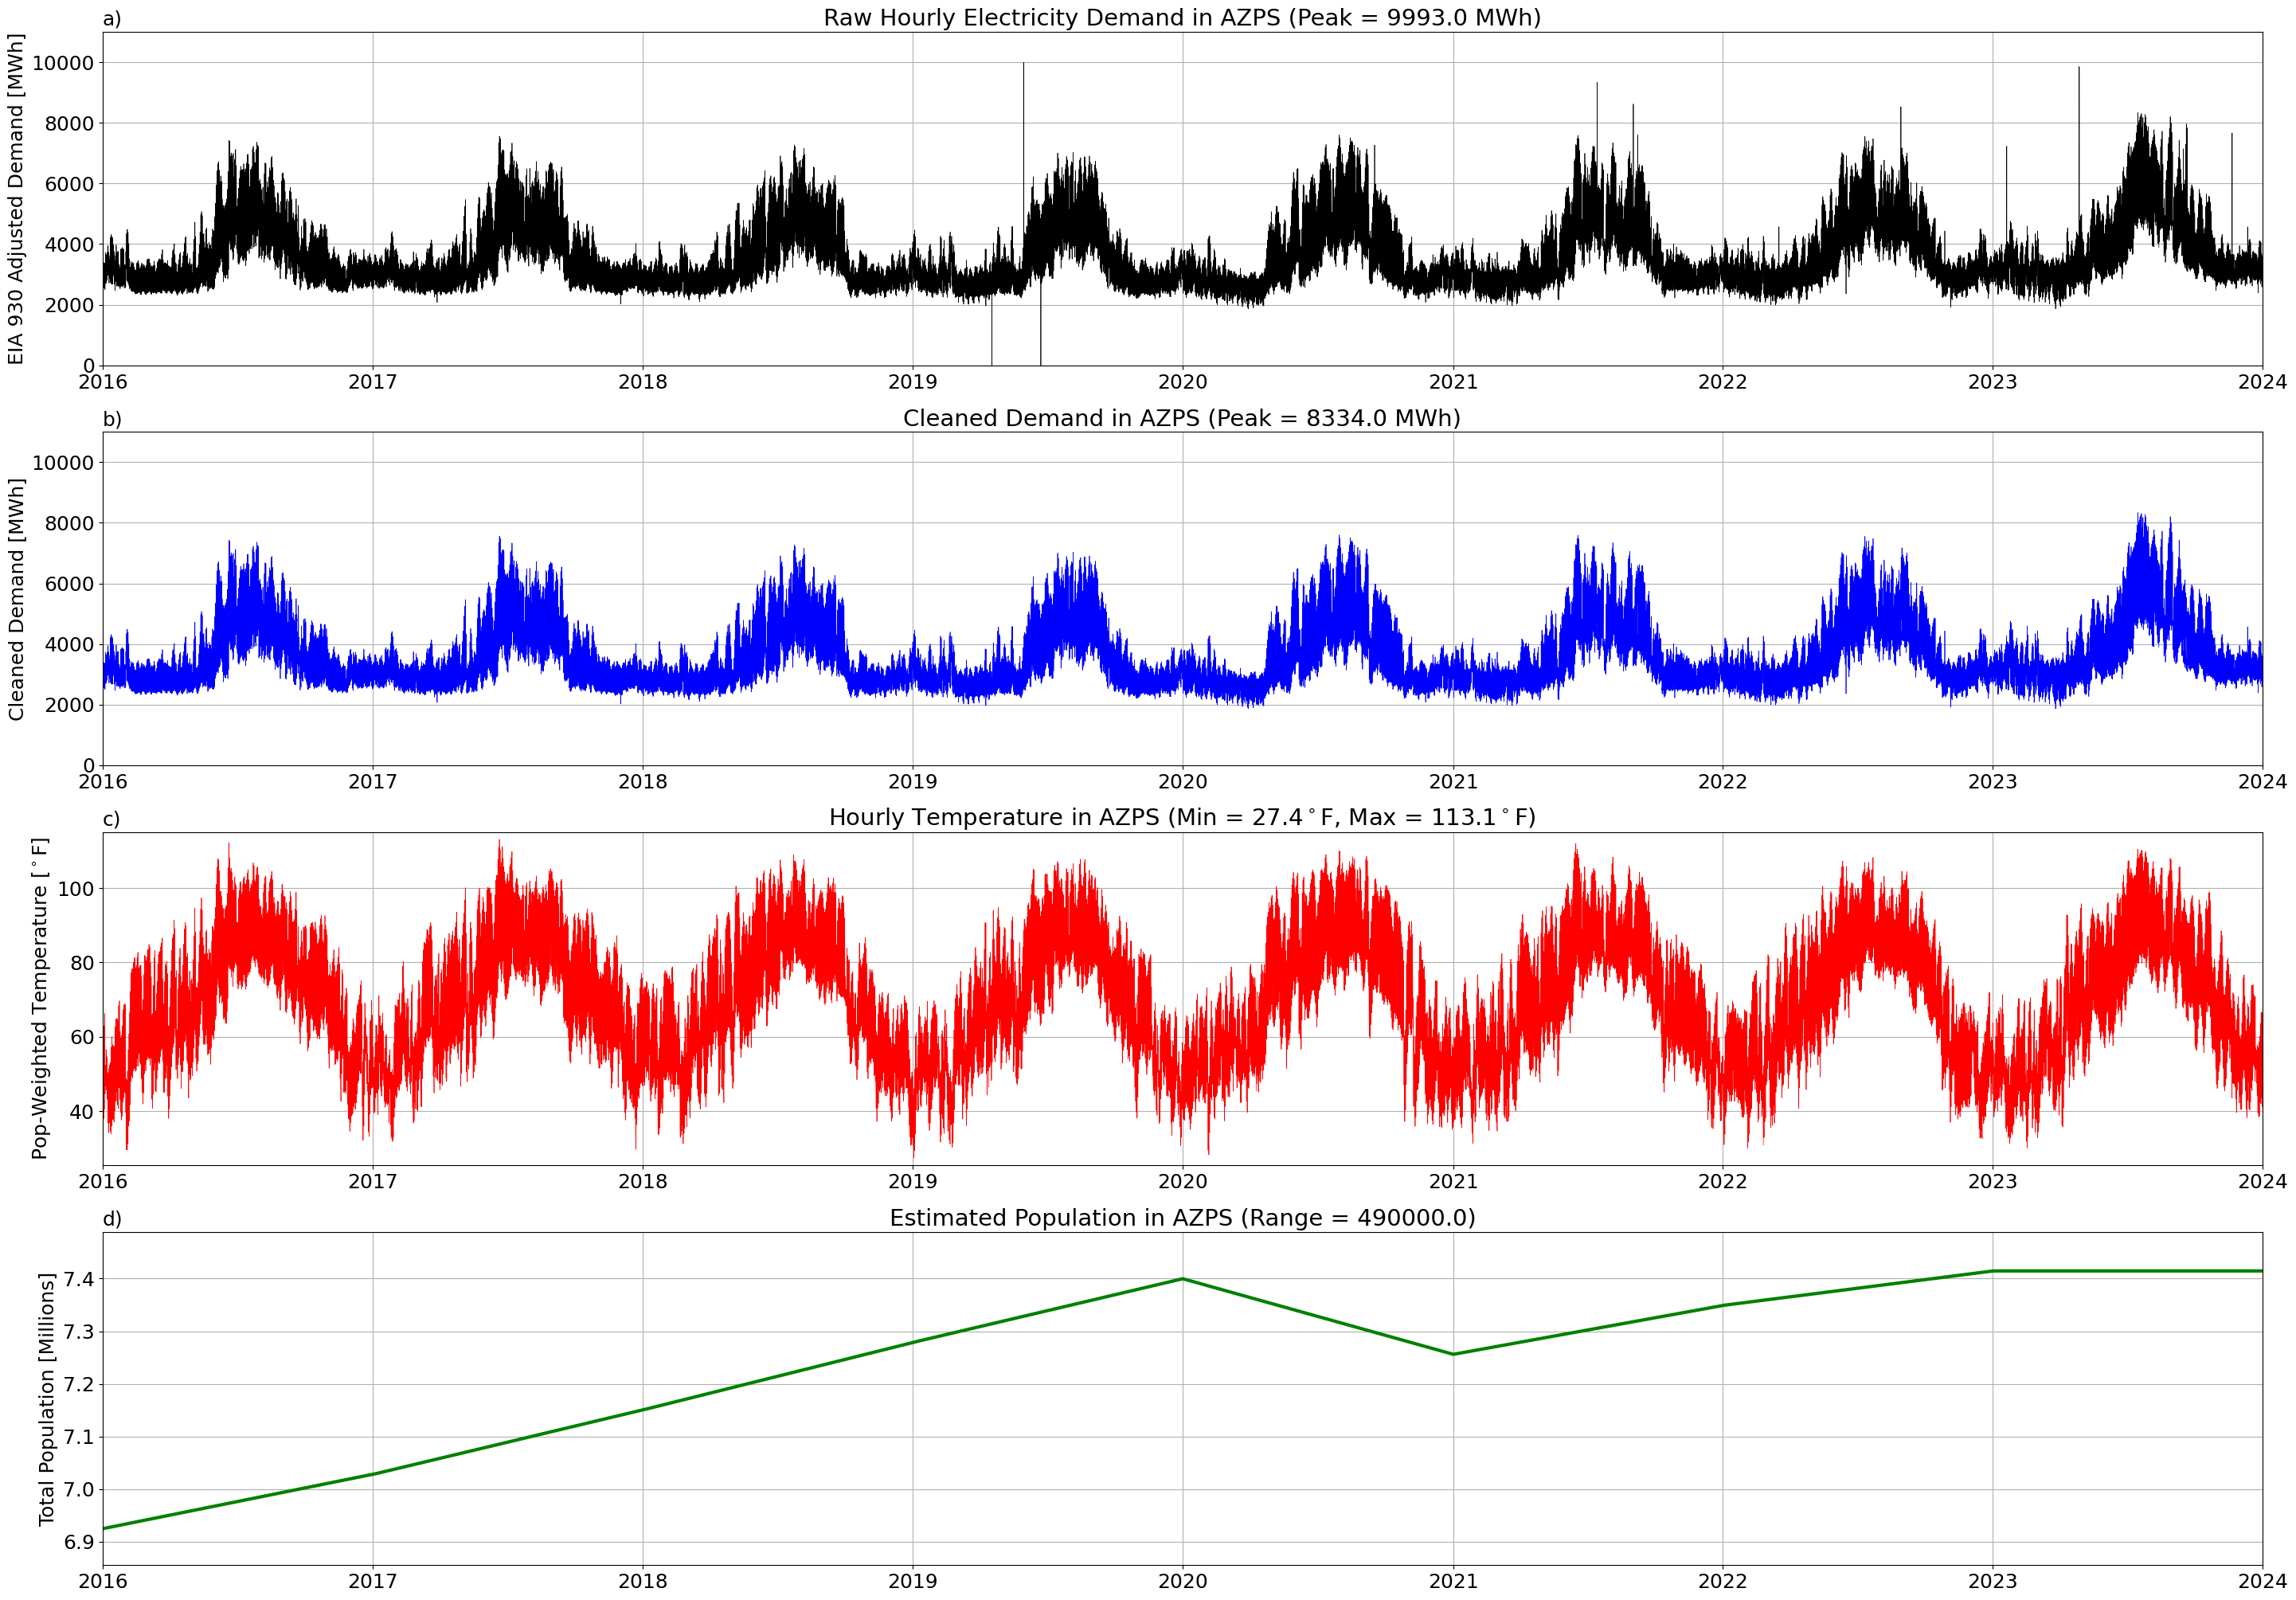

In [57]:
# Loop over the BAs and make the plot for each one:
for ba in ['AZPS']:
    output_df = plot_load_weather_time_series(ba_to_plot = ba,
                                              start_year = 2016,
                                              end_year = 2023,
                                              ba_data_input_dir = ba_data_input_dir,
                                              image_output_dir = image_output_dir, 
                                              image_resolution = 300, 
                                              save_images = True)
